# Problem Statement : Credit Card Fraud Detection

For many banks, retaining high profitable customers is the number one business goal. Banking fraud, however, poses a significant threat to this goal for different banks. In terms of substantial financial losses, trust and credibility, this is a concerning issue to both banks and customers alike.

**Business Understanding:**
    Credit card fraud is any dishonest act or behaviour to obtain information without proper authorisation from the account holder for financial gain. Among different ways of committing frauds, skimming is the most common one, which is a way of duplicating information that is located on the magnetic strip of the card. Apart from this, the other ways are as follows:

- Manipulation/alteration of genuine cards
- Creation of counterfeit cards
- Stealing/loss of credit cards
- Fraudulent telemarketing
 

Credit Card Fraud Detection is a highly data-imbalance problem where the number of fraud transactions is much lesser than the number of non-fraudulent transaction for any bank.Our aim involves building model on such imbalanced data, and thus produce results on real-time new data. So, we can consider this as an abnormality detection task.

**Task:**
- What are the general trends for Credit Card Fraud Transactions?
- What are the most important features that help us decide if the transaction is fraudulent or not?
- How do we balance the data to not let the model overfit on legitimate transactions?
- How to find the best performing model with the help of hyperparameter tuning ?

In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 20, 10
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn import tree
import graphviz
import time
import random
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_correlation_mat(df, show=True,cmap="RdBu"):
    title = "Correlation matrix"
    plt.figure()
    corr_metrics_df = df.corr()
    fig = sns.heatmap(corr_metrics_df, annot=True, cmap=cmap)
    plt.figure(figsize=(20, 10))
    plt.title(title, fontsize=20)
    if show:
        return plt,corr_metrics_df
    else:
        my_stringIObytes = StringIO()
        plt.savefig(my_stringIObytes, format='png')
        my_stringIObytes.seek(0)
        my_base64_jpgData = base64.b64encode(my_stringIObytes.read())
        return my_base64_jpgData,corr_metrics_df
    
def get_distplot(df, x,target=None,show= True):
    title= x.title()+ ' Distribution'
    #fig = create_distplot([df[c] for c in col_list], col_list)
    if target:
        palette= sns.color_palette('bright')[:len(df['target'].unique())]
    else:
        palette= None
    plt.figure()
    fig = sns.displot(data=df,x= x,hue=target,kind='kde', fill=True, palette=palette)
    plt.xlabel(x, fontsize=16)
    plt.title(title, fontsize=20)
    if show:
        return plt
    else:
        my_stringIObytes = StringIO()
        plt.savefig(my_stringIObytes, format='png')
        my_stringIObytes.seek(0)
        my_base64_jpgData = base64.b64encode(my_stringIObytes.read())
        return my_base64_jpgData

def get_redundant_pairs(frame):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = frame.columns
    for i in range(0, frame.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5,target= None):
    if target:
        frame= df.drop(target,axis=1)
    au_corr = frame.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(frame)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def get_vif(frame):
    vif_df = pd.DataFrame()
    vif_df['Features'] = frame.columns.tolist()
    vif_df['VIF'] = [variance_inflation_factor(frame.values, i) for i in range(frame.shape[1])]
    vif_df.sort_values(by = "VIF", ascending = False,inplace=True)
    # vif= 'Fail, '+str(vif_df['VIF'].iloc[0]) if vif_df['VIF'].iloc[0] > 5 else 'Pass, '+str(vif_df['VIF'].iloc[0])
    vif= vif_df['VIF'].iloc[0]
    return vif_df,vif

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

def class_accuracy(threshold,model1,X_test,X_train,Y_test,Y_train,xgb=False):
    if xgb:
        Y_pred_class_test_all_class = model1.predict_proba(X_test.values)[:,1]
    else:
        Y_pred_class_test_all_class = model1.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(Y_test, Y_pred_class_test_all_class)
    xx = pd.DataFrame(Y_pred_class_test_all_class,index=X_test.index , columns = ["Yes"])
    Y_pred_class_test_all_class = xx["Yes"].apply(lambda x: 1 if x > threshold else 0)
    f1_test= f1_score(Y_test,Y_pred_class_test_all_class, average='weighted')
    mat = confusion_matrix(Y_test, Y_pred_class_test_all_class)
    tp = mat[1][1]
    fp = mat[0][1]
    tn = mat[0][0]
    fn = mat[1][0]
    precision = tp/float(tp+fp)
    sensitivity = tp/float(tp+fn)
    specificity = tn/float(tn+fp)
    GINI= (2*roc_auc)-1
    test_df = pd.DataFrame(columns= ['AUC','GINI','sensitivity','specificity','F1 Score','False Positive','True Positive','False Negative','True Negative','IU'],index=[threshold])
    test_df.index.names=['Prob Cut-Off %']
    test_df['sensitivity'] =[sensitivity]
    test_df['specificity'] =[specificity]
    test_df['F1 Score'] =[f1_test]
    test_df['GINI'] =[GINI]
    test_df['AUC'] =[roc_auc]
    test_df['False Positive'] =[fp]
    test_df['True Positive'] =[tp]
    test_df['False Negative'] =[fn]
    test_df['True Negative'] =[tn]
    test_df['IU'] = abs(test_df['sensitivity'] - roc_auc) + abs(test_df['specificity'] - roc_auc)
    if xgb:
        Y_pred_class_train =  model1.predict_proba(X_train.values)[:,1]
    else:
        Y_pred_class_train =  model1.predict_proba(X_train)[:,1]
    # Y_pred_class_train =  model1.predict(X_train)
    roc_auc = roc_auc_score(Y_train, Y_pred_class_train)
    xx = pd.DataFrame(Y_pred_class_train,index=X_train.index , columns = ["Yes"])
    Y_pred_class_train = xx["Yes"].apply(lambda x: 1 if x > threshold else 0)
    f1_train= f1_score(Y_train,Y_pred_class_train, average='weighted')
    mat = confusion_matrix(Y_train, Y_pred_class_train)
    tp = mat[1][1]
    fp = mat[0][1]
    tn = mat[0][0]
    fn = mat[1][0]
    precision = tp/float(tp+fp)
    sensitivity = tp/float(tp+fn)
    specificity = tn/float(tn+fp)
    GINI= (2*roc_auc)-1
    train_df = pd.DataFrame(columns= ['AUC','GINI','sensitivity','specificity','F1 Score','False Positive','True Positive','False Negative','True Negative','IU'],index=[threshold])
    train_df.index.names=['Prob Cut-Off %']
    train_df['sensitivity'] =[sensitivity]
    train_df['specificity'] =[specificity]
    train_df['F1 Score'] =[f1_train]
    train_df['GINI'] =[GINI]
    train_df['AUC'] =[roc_auc]
    train_df['False Positive'] =[fp]
    train_df['True Positive'] =[tp]
    train_df['False Negative'] =[fn]
    train_df['True Negative'] =[tn]
    train_df['IU'] = abs(train_df['sensitivity'] - roc_auc) + abs(train_df['specificity'] - roc_auc)
    return train_df,test_df

**Load The Data**

In [3]:
df= pd.read_csv('creditcard.csv')
df.shape

(284807, 31)

In [4]:
df.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [5]:
df.rename(columns={'Class':'target'},inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,target
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [8]:
### Checking For Missig values

In [9]:
df.columns[df.isnull().any()]

Index([], dtype='object')

No missing values

**Data Understanding**

- The Data has 31 features from V1-V28, Time, Amount and Class.
- Our target variable is 'Class'.
- The Data does not have any missing values as evident from the above code, thus we need not do any missing value handling or so.
- The Data consists of all numerical features, and only the Target Variable 'Class' is a categorical feature.
- Class 0: Non-Fraudulent Transaction
- Class 1: Fraud Transaction

In [10]:
### Checking for duplicate records

In [11]:
print (df.shape)
print (df.drop_duplicates().shape)

(284807, 31)
(283726, 31)


Duplicates were present so removing those

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
### Checking distribution of target variable

In [14]:
df['target'].value_counts(dropna=False)

0    283253
1       473
Name: target, dtype: int64

In [15]:
df['target'].value_counts(normalize=True,dropna=False)*100

0    99.83329
1     0.16671
Name: target, dtype: float64

### EDA

<Figure size 1440x720 with 0 Axes>

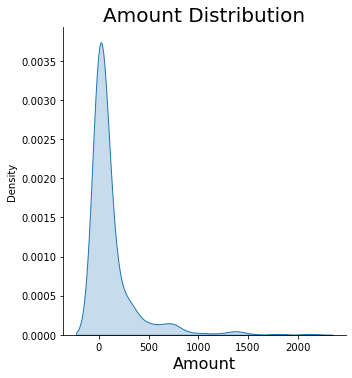

In [16]:
## Fraud customers
plt= get_distplot(df=df[df['target'] == 1], x='Amount',target=None)
plt.show()

<Figure size 1440x720 with 0 Axes>

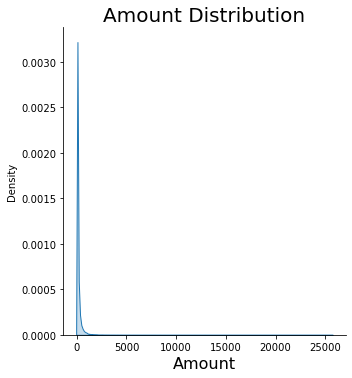

In [17]:
## Non-Fraud customers
plt= get_distplot(df=df[df['target'] == 0], x='Amount',target=None)
plt.show()

Fraud customers are mostly concentrated at lower range amount i.e. less than 500.

In [18]:
get_top_abs_correlations(df,n=5,target= 'target')

V2    Amount    0.533428
Time  V3        0.422054
V7    Amount    0.400408
V5    Amount    0.387685
V20   Amount    0.340729
dtype: float64

### Skewness

We don't see much correlation between the independent features

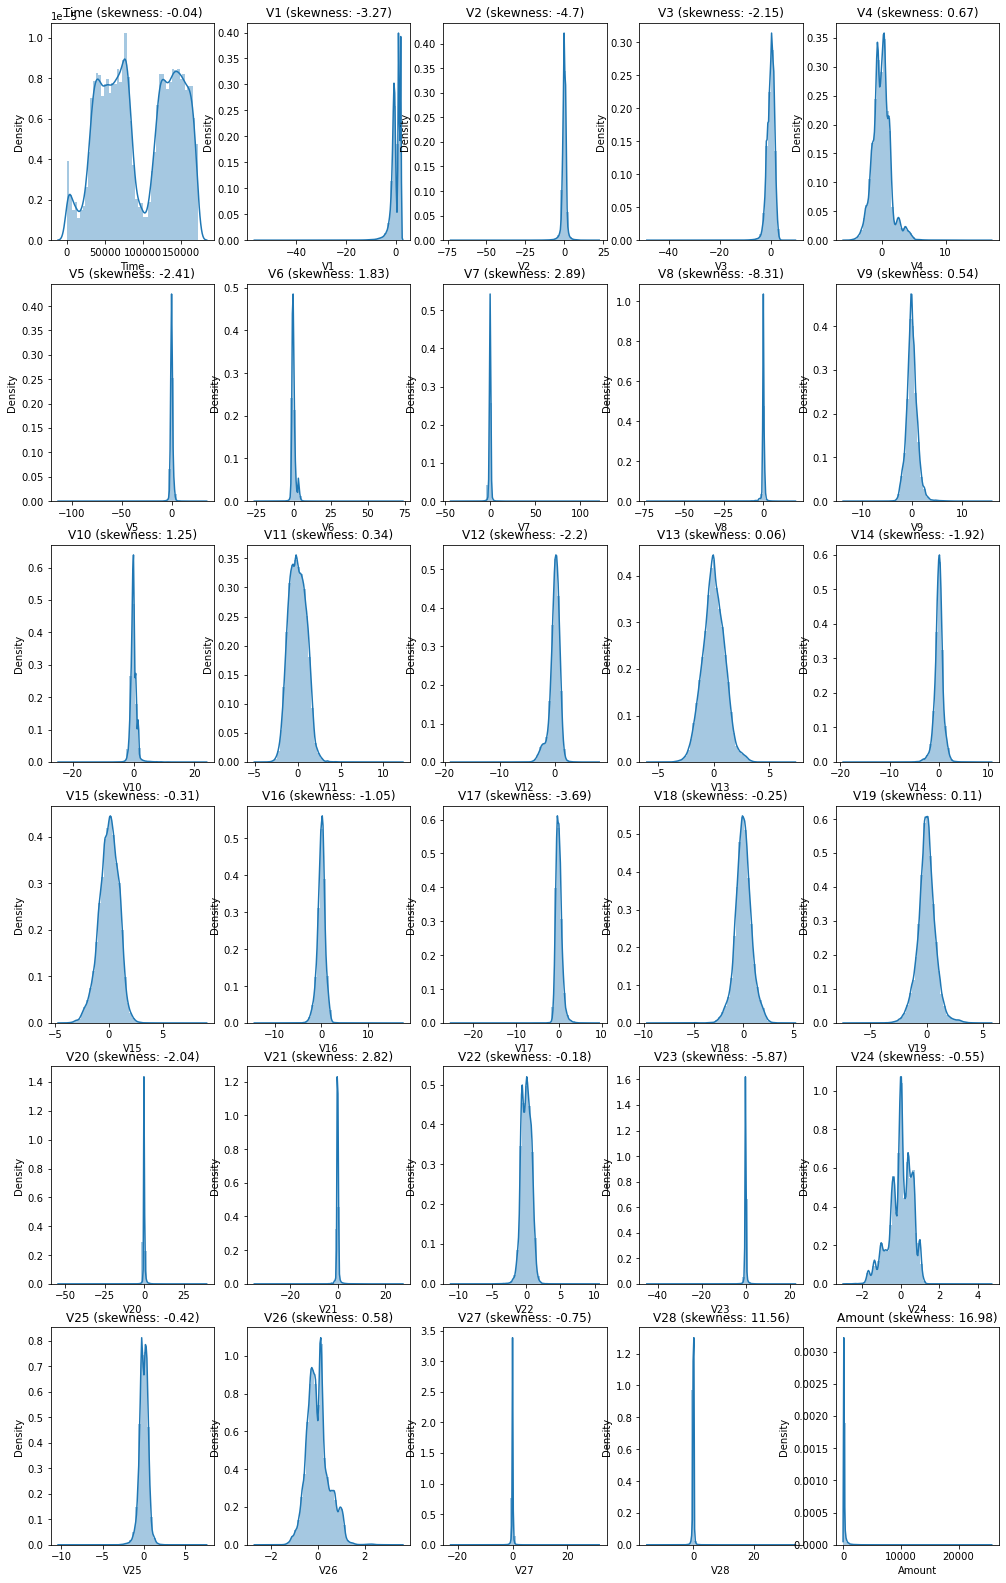

In [19]:
k=0
plt.figure(figsize=(17,28))
for col in df.drop('target',axis=1).columns:    
    k=k+1
    plt.subplot(6, 5,k)    
    sns.distplot(df[col])
    plt.title(col+' (skewness: '+str(round(df[col].skew(),2))+')')

In [20]:
df[df.drop('target',axis=1).columns].skew().sort_values(ascending=False)

Amount    16.978803
V28       11.555115
V7         2.890271
V21        2.820033
V6         1.829880
V10        1.252967
V4         0.671504
V26        0.580292
V9         0.537663
V11        0.344074
V19        0.108312
V13        0.064293
Time      -0.035581
V22       -0.182330
V18       -0.248661
V15       -0.309659
V25       -0.415744
V24       -0.552129
V27       -0.753804
V16       -1.051161
V14       -1.918804
V20       -2.043121
V3        -2.151984
V12       -2.199008
V5        -2.414079
V1        -3.273271
V17       -3.690497
V2        -4.695162
V23       -5.867221
V8        -8.310970
dtype: float64

Features "Amount" and "V28" are highly right skewed

Features "V8", "V23", "V2", "V17" and "V1" are highly left skewed

Skew before transform:  16.978803370060476
Skew after transform:  0.08660020747979622


<AxesSubplot:>

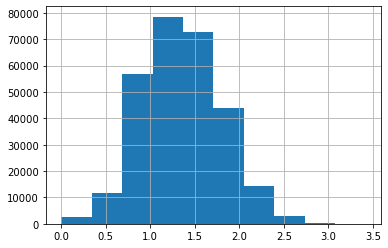

In [21]:
feat= 'Amount'
print ('Skew before transform: ',df[feat].skew())
transfomed= np.log1p(np.cbrt(df[feat]))
# transfomed= np.cbrt(df[feat])
print ('Skew after transform: ',transfomed.skew())
transfomed.hist(figsize=(6, 4))

Skew before transform:  11.555115084196773
Skew after transform:  -0.8369555399427066


<AxesSubplot:>

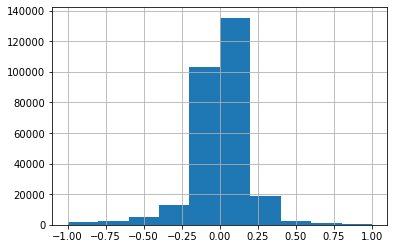

In [22]:
feat= 'V28'
print ('Skew before transform: ',df[feat].skew())
transfomed= np.tanh(df[feat])
# transfomed= np.log1p(np.cbrt(df[feat]))
print ('Skew after transform: ',transfomed.skew())
transfomed.hist(figsize=(6, 4))

Skew before transform:  -8.310970330052545
Skew after transform:  -0.08013877420164228


<AxesSubplot:>

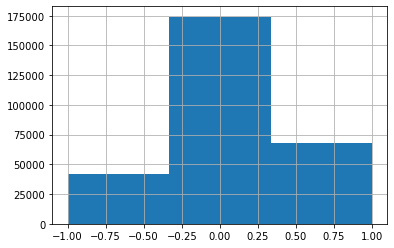

In [23]:
feat= 'V8'
print ('Skew before transform: ',df[feat].skew())
# transfomed= pd.Series(np.cbrt(df[feat]))
transfomed= pd.Series(np.tanh(df[feat]))
print ('Skew after transform: ',transfomed.skew())
transfomed.hist(figsize=(6, 4),bins=3)

Skew before transform:  -5.867220791006341
Skew after transform:  0.193531723680468


<AxesSubplot:>

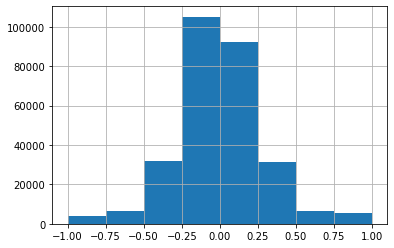

In [24]:
feat= 'V23'
print ('Skew before transform: ',df[feat].skew())
# transfomed= pd.Series(stats.boxcox(np.cbrt(df[feat]))[0])
# transfomed= pd.Series(np.log1p(np.cbrt(df[feat])))
# transfomed= pd.Series(np.cbrt(df[feat]))
transfomed= pd.Series(np.tanh(df[feat]))
print ('Skew after transform: ',transfomed.skew())
transfomed.hist(figsize=(6, 4),bins=8)

Skew before transform:  -4.6951619005404694
Skew after transform:  -0.16293469571238514


<AxesSubplot:>

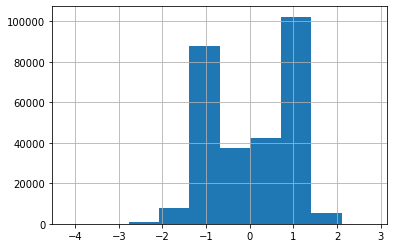

In [25]:
feat= 'V2'
print ('Skew before transform: ',df[feat].skew())
# transfomed= pd.Series(np.tanh(df[feat]))
transfomed= pd.Series(np.cbrt(df[feat]))
print ('Skew after transform: ',transfomed.skew())
transfomed.hist(figsize=(6, 4),bins=10)

Skew before transform:  -3.690497194148406
Skew after transform:  0.23104298849460952


<AxesSubplot:>

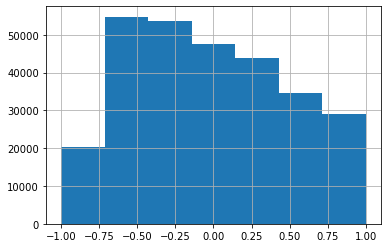

In [26]:
feat= 'V17'
print ('Skew before transform: ',df[feat].skew())
transfomed= pd.Series(np.tanh(df[feat]))
# transfomed= pd.Series(np.cbrt(df[feat]))
print ('Skew after transform: ',transfomed.skew())
transfomed.hist(figsize=(6, 4),bins=7)

Skew before transform:  -3.273271248440309
Skew after transform:  -0.11138319099713426


<AxesSubplot:>

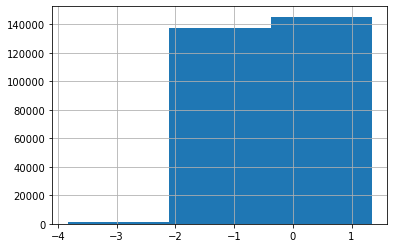

In [27]:
feat= 'V1'
print ('Skew before transform: ',df[feat].skew())
# transfomed= pd.Series(np.tanh(df[feat]))
transfomed= pd.Series(np.cbrt(df[feat]))
print ('Skew after transform: ',transfomed.skew())
transfomed.hist(figsize=(6, 4),bins=3)

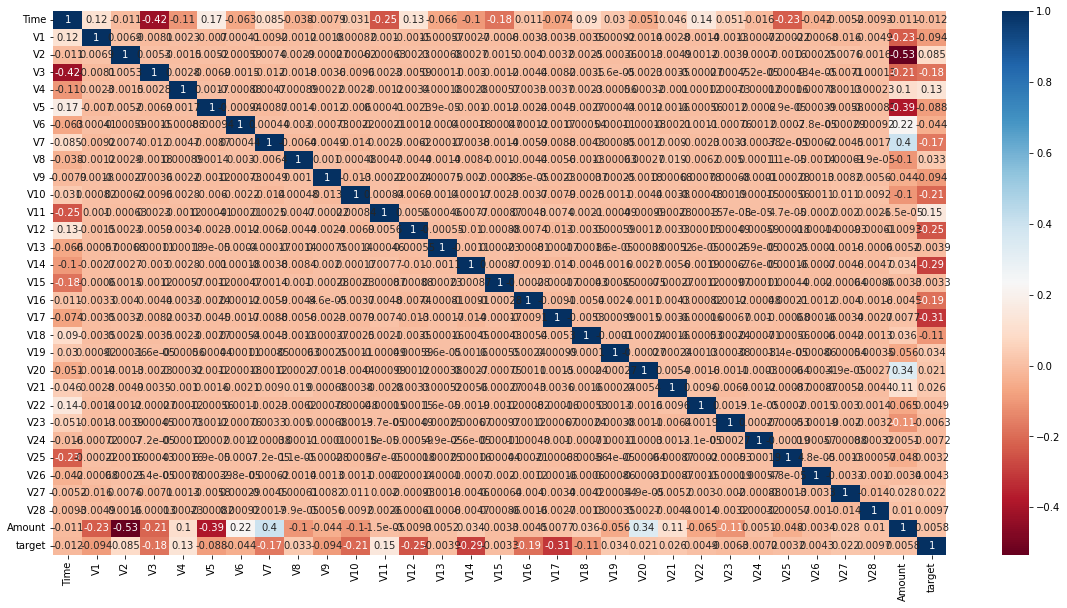

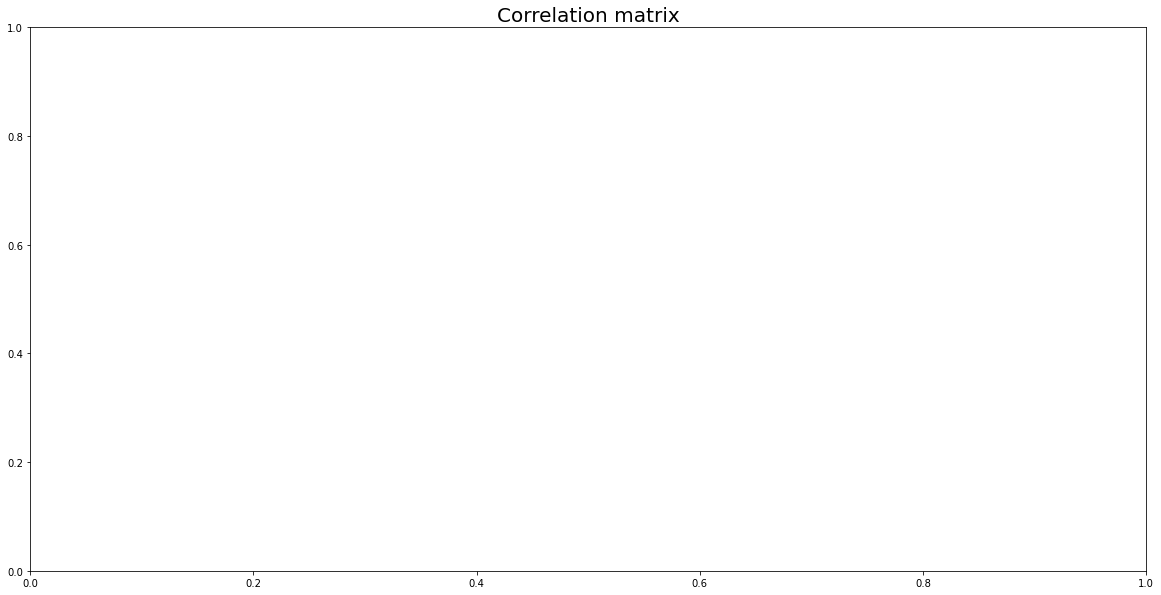

In [28]:
plt,corr_metrics_df= get_correlation_mat(df)

In [29]:
np.abs(corr_metrics_df[corr_metrics_df['target'] != 1][['target']]).sort_values('target',ascending= False)

,target
V17,0.313498
V14,0.293375
V12,0.250711
V10,0.206971
V16,0.187186
V3,0.182322
V7,0.172347
V11,0.149067
V4,0.129326
V18,0.105340


<AxesSubplot:>

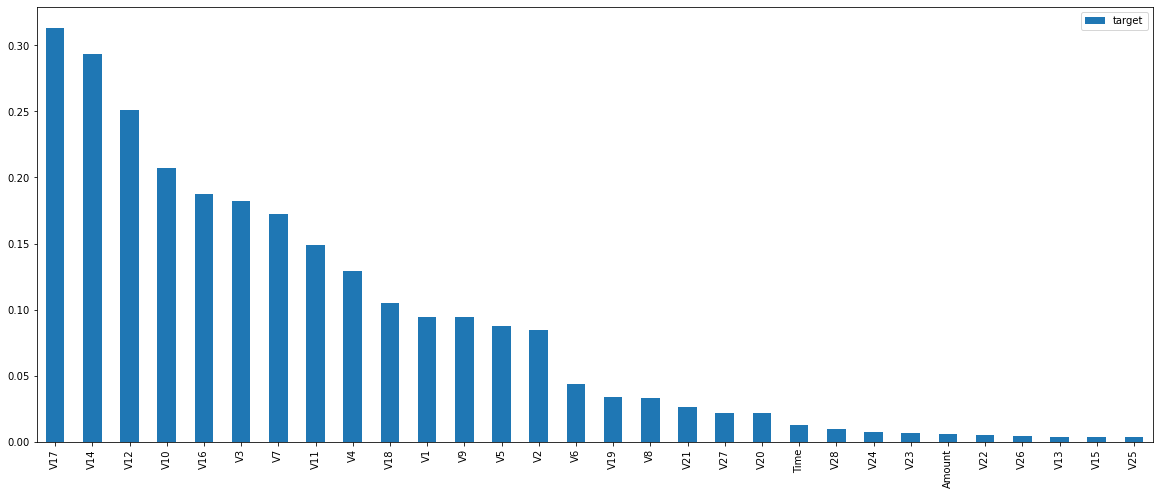

In [30]:
## feature importance as per the pearsons correlation with the target variable
np.abs(corr_metrics_df[corr_metrics_df['target'] != 1][['target']]).sort_values('target',ascending= False).plot.bar(figsize=(20,8))

V24, V23, V22, V26, V13, V15, V25 and Amount have less than 10% correlation with our target varible

We will remove the above feature incrementally in the future steps while buildig the mode if needed

Performing transformation to handle features with high skewness

**Reducing Skewness:**

In [31]:
## transformations to reduce skewness
amount_transfomed= np.log1p(np.cbrt(df['Amount']))
df['Amount_cbrt_log']= amount_transfomed

v28_transfomed= np.tanh(df['V28'])
df['V28_tanh']= v28_transfomed

v8_transfomed= pd.Series(np.tanh(df['V8']))
df['V8_tanh']= v8_transfomed

v23_transfomed= pd.Series(np.tanh(df['V23']))
df['V23_tanh']= v23_transfomed

# v2_transfomed= pd.Series(np.cbrt(df['V2']))
# df['V2_cbrt']= v2_transfomed

In [32]:
tmp_og= df.copy(deep=True)

In [33]:
##droping original feature after transformation has been performed
df.drop(columns= ['Amount','V28','V8','V23'],axis=1, inplace=True)

As we can see that Amount has high correlation with other independent features and very less correlation with our target variable, we will remove Amount feature

In [34]:
## removing redundant column
df.drop(columns=['Time','Amount_cbrt_log'], axis=1,inplace=True)

**Train-Test Split**

In [35]:
# np.random.seed(0)
##keepig the train size to 80% and test size to 20%
df_train, df_test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 0, 
                                     stratify=df['target']) #

In [36]:
# ### standardising amount column
# sc = StandardScaler()
# amount = df_train['Amount'].values
# df_train['Amount_scaled'] = sc.fit_transform(amount.reshape(-1, 1))

## Handling Imbalanced Data

In [37]:
X_train= df_train.drop(columns=['target'], axis=1)
y_train= df_train['target']


X_test= df_test.drop(columns=['target'], axis=1)
y_test= df_test['target']

In [38]:
print (y_train.value_counts())
print (y_test.value_counts())

0    226602
1       378
Name: target, dtype: int64
0    56651
1       95
Name: target, dtype: int64


In [39]:
vif_df,vif= get_vif(X_train)
vif_df.head(2)

,Features,VIF
26,V8_tanh,1.365781
27,V23_tanh,1.191876


In [40]:
##increasing the fraud labels to ~10%
X_ada_train, y_ada_train = SMOTE(sampling_strategy=0.1,random_state=420).fit_resample(X_train, y_train)
# X_ada_train, y_ada_train = X_train, y_train
print (X_ada_train.shape)
y_ada_train.value_counts(normalize=True)

(249262, 28)


0    0.909092
1    0.090908
Name: target, dtype: float64

As seen above there doesn't seem to be much multicorrelation between the dependent features

## Base Logistic Regression Model

In [41]:
model = LogisticRegression(random_state=420)
model.fit(X_ada_train, y_ada_train)

model_stat=pd.DataFrame(zip(['Intercept']+X_ada_train.columns.tolist(),[model.intercept_.tolist()[0]]+model.coef_.tolist()[0]),columns=['Model Parameter','Model Coefficient'])

# check the accuracy on the training set
testdf=pd.DataFrame()
traindf=pd.DataFrame()
cut_off = np.linspace(0,1,60)
for thresh in cut_off:
    train_df,test_df= class_accuracy(thresh,model,X_test,X_ada_train,y_test,y_ada_train)
    traindf = traindf.append(train_df)
    testdf = testdf.append(test_df)
traindf.reset_index(inplace=True)
testdf.reset_index(inplace=True)
print ('Train AUC: ',traindf['AUC'].iloc[0])
print ('Test AUC: ',testdf['AUC'].iloc[0])

Train AUC:  0.9882400122737369
Test AUC:  0.9788988720410937


In [42]:
traindf[3:13]

,Prob Cut-Off %,AUC,GINI,sensitivity,specificity,F1 Score,False Positive,True Positive,False Negative,True Negative,IU
3,0.050847,0.98824,0.97648,0.940909,0.952631,0.955211,10734,21321,1339,215868,0.082940
4,0.067797,0.98824,0.97648,0.926831,0.966752,0.964997,7534,21002,1658,219068,0.082896
5,0.084746,0.98824,0.97648,0.918623,0.974930,0.970860,5681,20816,1844,220921,0.082927
6,0.101695,0.98824,0.97648,0.911783,0.979753,0.974212,4588,20661,1999,222014,0.084944
7,0.118644,0.98824,0.97648,0.904810,0.982997,0.976278,3853,20503,2157,222749,0.088673
8,0.135593,0.98824,0.97648,0.896514,0.985344,0.977484,3321,20315,2345,223281,0.094622
9,0.152542,0.98824,0.97648,0.890997,0.987132,0.978487,2916,20190,2470,223686,0.098351
10,0.169492,0.98824,0.97648,0.887070,0.988508,0.979296,2604,20101,2559,223998,0.101439
11,0.186441,0.98824,0.97648,0.883451,0.989554,0.979854,2367,20019,2641,224235,0.106103
12,0.203390,0.98824,0.97648,0.879788,0.990402,0.980237,2175,19936,2724,224427,0.110614


In [43]:
testdf[3:13]

,Prob Cut-Off %,AUC,GINI,sensitivity,specificity,F1 Score,False Positive,True Positive,False Negative,True Negative,IU
3,0.050847,0.978899,0.957798,0.926316,0.950663,0.973113,2795,88,7,53856,0.080819
4,0.067797,0.978899,0.957798,0.926316,0.965738,0.981002,1941,88,7,54710,0.065744
5,0.084746,0.978899,0.957798,0.915789,0.973769,0.985163,1486,87,8,55165,0.068239
6,0.101695,0.978899,0.957798,0.915789,0.978994,0.987871,1190,87,8,55461,0.063205
7,0.118644,0.978899,0.957798,0.905263,0.982595,0.989729,986,86,9,55665,0.077332
8,0.135593,0.978899,0.957798,0.894737,0.984978,0.990959,851,85,10,55800,0.090241
9,0.152542,0.978899,0.957798,0.894737,0.987255,0.992151,722,85,10,55929,0.092518
10,0.169492,0.978899,0.957798,0.894737,0.988632,0.992876,644,85,10,56007,0.093895
11,0.186441,0.978899,0.957798,0.894737,0.989656,0.993419,586,85,10,56065,0.094919
12,0.203390,0.978899,0.957798,0.894737,0.990521,0.993881,537,85,10,56114,0.095784


<AxesSubplot:>

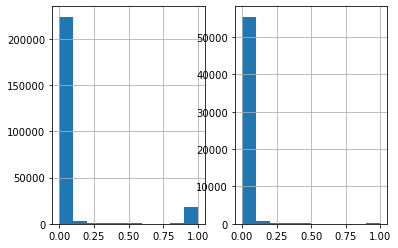

In [44]:
##Probability Distribution
fig, axes = plt.subplots(1, 2)
##Train
pd.Series(model.predict_proba(X_ada_train)[:,1]).hist(figsize=(6, 4), ax=axes[0])
##Test
pd.Series(model.predict_proba(X_test)[:,1]).hist(figsize=(6, 4), ax=axes[1])

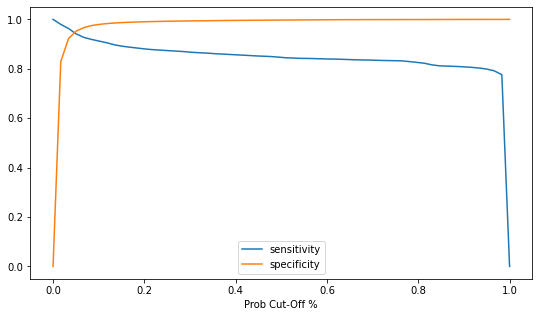

In [45]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
traindf.plot.line(x='Prob Cut-Off %', y=['sensitivity','specificity'],figsize=(9, 5))
plt.show()

- auc roc_value: 0.988
- threshold: 5%
- auc roc_value test dataset: 0.978

**Inference**
- The model is performing pretty good
- V8_tanh, V10, V4, V28_tanh are the top 4 features in the model
- We can see that the model is slightly overfitting to some extent but it's very negligible.
- Probability cut-off should be ~5% as it gives stable sensitivity (95%) and specificity (94%)
- We will use this as the baseline model


In [46]:
model_output= (X_ada_train.columns.tolist(),model)
output = open('LR_credit_fraud.pkl', 'wb')
pickle.dump(model_output, output)
output.close()

## Decision Tree Classifier

In [47]:
##Base Model
model = DecisionTreeClassifier(random_state=420)
model.fit(X_ada_train, y_ada_train)

model_stat= pd.DataFrame(zip(X_ada_train.columns,model.feature_importances_),columns=['Model Parameters','Weightage'])
model_stat.sort_values('Weightage',ascending=False,inplace=True)

# check the accuracy on the training set
testdf=pd.DataFrame()
traindf=pd.DataFrame()
cut_off = np.linspace(0,1,2)
for thresh in cut_off:
    train_df,test_df= class_accuracy(thresh,model,X_test,X_ada_train,y_test,y_ada_train)
    traindf = traindf.append(train_df)
    testdf = testdf.append(test_df)
traindf.reset_index(inplace=True)
testdf.reset_index(inplace=True)
print ('Train AUC: ',traindf['AUC'].iloc[0])
print ('Test AUC: ',testdf['AUC'].iloc[0])

Train AUC:  1.0
Test AUC:  0.8724662267307959


In [48]:
# ##Generate tree
# dot_data = tree.export_graphviz(model, out_file=None, 
#                                     feature_names=X_ada_train.columns,  
#                                     class_names='fraud',
#                                     proportion=True,
#                                     filled=True)
# plt.figure()
# graph = graphviz.Source(dot_data, format="png")
# graph

**Inference**
- The model is clearly overfitting
- V14, V4, V8_tanh, V1 are the top 4 features in the model
- We will need to fine tune the hyperparameters to reduce the overfitting

### Perform hyperparameter tuning to reduce overfitting and get better overall performace

In [49]:
## we want to optimise two main hyperparameters i.e. max depth and minimum samples in leaf node

In [50]:
##Keeping max_depth = 10
model = DecisionTreeClassifier(random_state=420,max_depth=10)
model.fit(X_ada_train, y_ada_train)
# check the accuracy on the training set
testdf=pd.DataFrame()
traindf=pd.DataFrame()
thresh= 0
train_df,test_df= class_accuracy(thresh,model,X_test,X_ada_train,y_test,y_ada_train)
traindf = traindf.append(train_df)
testdf = testdf.append(test_df)
traindf.reset_index(inplace=True)
testdf.reset_index(inplace=True)
print ('Train AUC: ',traindf['AUC'].iloc[0])
print ('Test AUC: ',testdf['AUC'].iloc[0])

Train AUC:  0.9971398512649754
Test AUC:  0.9064739880096881


In [51]:
len(X_ada_train)*0.01

2492.62

In [52]:
##Keeping min_samples_leaf = 100
model = DecisionTreeClassifier(random_state=420,min_samples_leaf=1000)
model.fit(X_ada_train, y_ada_train)
# check the accuracy on the training set
testdf=pd.DataFrame()
traindf=pd.DataFrame()
thresh= 0
train_df,test_df= class_accuracy(thresh,model,X_test,X_ada_train,y_test,y_ada_train)
traindf = traindf.append(train_df)
testdf = testdf.append(test_df)
traindf.reset_index(inplace=True)
testdf.reset_index(inplace=True)
print ('Train AUC: ',traindf['AUC'].iloc[0])
print ('Test AUC: ',testdf['AUC'].iloc[0])

Train AUC:  0.9949473143393209
Test AUC:  0.9525163768187304


- As we saw above max_depth at 10 is still overfitting so it can't be more than 10. Also we have high number of features so we will keep the minimum depth as 5.
- With min_samples_leaf=1000, the model is still slightly overfitting

In [53]:
##Perform gridsearchcv
model = DecisionTreeClassifier(random_state=420)
params = {
    'max_depth': [4,5, 6, 7],
    'min_samples_leaf': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'max_features': [8,10,12,15,17],
    'criterion': ["entropy",'gini']
        }

grid_search = GridSearchCV(estimator=model, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "roc_auc",return_train_score=True)

grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 400 candidates, totalling 1600 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=420),
             n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [4, 5, 6, 7],
                         'max_features': [8, 10, 12, 15, 17],
                         'min_samples_leaf': [50, 100, 150, 200, 250, 300, 350,
                                              400, 450, 500]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [54]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.nlargest(6,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,params,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
134,4.742383,0.223096,0.037042,0.003698,entropy,6,15,250,"{'criterion': 'entropy', 'max_depth': 6, 'max_...",0.978007,...,0.949952,0.965568,0.010083,1,0.989388,0.990976,0.991775,0.993642,0.991445,0.001532
85,4.149836,0.044317,0.037670,0.001655,entropy,5,15,300,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.963557,...,0.961583,0.964967,0.002502,2,0.979919,0.981709,0.983742,0.987248,0.983154,0.002723
84,4.186053,0.024636,0.034514,0.003401,entropy,5,15,250,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.967201,...,0.957994,0.962853,0.003983,3,0.979831,0.981694,0.984288,0.987345,0.983290,0.002826
35,3.317146,0.024524,0.040441,0.007929,entropy,4,15,300,"{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.955347,...,0.958589,0.962346,0.005606,4,0.969984,0.973738,0.973625,0.978646,0.973998,0.003079
34,3.314956,0.013438,0.032693,0.003641,entropy,4,15,250,"{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.955315,...,0.955168,0.960270,0.005646,5,0.970034,0.973577,0.972027,0.978669,0.973577,0.003197
40,3.741337,0.030864,0.035423,0.002781,entropy,4,17,50,"{'criterion': 'entropy', 'max_depth': 4, 'max_...",0.961847,...,0.962720,0.959836,0.008271,6,0.977234,0.973990,0.958465,0.972318,0.970502,0.007171


In [55]:
model_best= grid_search.best_estimator_
model_best.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 15,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 250,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 420,
 'splitter': 'best'}

In [56]:
grid_search= None; del grid_search

In [57]:
model= model_best.fit(X_ada_train, y_ada_train)
# check the accuracy on the training set
testdf=pd.DataFrame()
traindf=pd.DataFrame()
cut_off = np.linspace(0,1,2)
for thresh in cut_off:
    train_df,test_df= class_accuracy(thresh,model,X_test,X_ada_train,y_test,y_ada_train)
    traindf = traindf.append(train_df)
    testdf = testdf.append(test_df)
traindf.reset_index(inplace=True)
testdf.reset_index(inplace=True)
print ('Train AUC: ',traindf['AUC'].iloc[0])
print ('Test AUC: ',testdf['AUC'].iloc[0])

Train AUC:  0.9891743571881765
Test AUC:  0.9553212699362393


There is still overfitting happening

In [58]:
## manual finetuneing
#increasing the min_sampe_leaf, reducing the max_depth and increasing the max_features
model = DecisionTreeClassifier(random_state=420,max_depth=4,min_samples_leaf= 300,
                               criterion= 'entropy',max_features=8)
model.fit(X_ada_train, y_ada_train)
model_stat= pd.DataFrame(zip(X_ada_train.columns,model.feature_importances_),columns=['Model Parameters','Weightage'])

# check the accuracy on the training set
testdf=pd.DataFrame()
traindf=pd.DataFrame()
cut_off = np.linspace(0,1,60)
for thresh in cut_off:
    train_df,test_df= class_accuracy(thresh,model,X_test,X_ada_train,y_test,y_ada_train)
    traindf = traindf.append(train_df)
    testdf = testdf.append(test_df)
traindf.reset_index(inplace=True)
testdf.reset_index(inplace=True)
print ('Train AUC: ',traindf['AUC'].iloc[0])
print ('Test AUC: ',testdf['AUC'].iloc[0])

Train AUC:  0.9611753739675365
Test AUC:  0.9546632242288657


In [59]:
model_stat= pd.DataFrame(zip(X_ada_train.columns,model.feature_importances_),columns=['Model Parameters','Weightage'])
model_stat.sort_values('Weightage',ascending=False)[:5]

,Model Parameters,Weightage
8,V10,0.805431
15,V17,0.078654
3,V4,0.043645
12,V14,0.035335
10,V12,0.021751


In [60]:
traindf[2:15]

,Prob Cut-Off %,AUC,GINI,sensitivity,specificity,F1 Score,False Positive,True Positive,False Negative,True Negative,IU
2,0.033898,0.961175,0.922351,0.897087,0.925905,0.931299,16790,20328,2332,209812,0.099358
3,0.050847,0.961175,0.922351,0.896470,0.927167,0.932158,16504,20314,2346,210098,0.098714
4,0.067797,0.961175,0.922351,0.851721,0.994254,0.980894,1302,19300,3360,225300,0.142533
5,0.084746,0.961175,0.922351,0.851721,0.994254,0.980894,1302,19300,3360,225300,0.142533
6,0.101695,0.961175,0.922351,0.851721,0.994254,0.980894,1302,19300,3360,225300,0.142533
7,0.118644,0.961175,0.922351,0.851721,0.994254,0.980894,1302,19300,3360,225300,0.142533
8,0.135593,0.961175,0.922351,0.851721,0.994254,0.980894,1302,19300,3360,225300,0.142533
9,0.152542,0.961175,0.922351,0.851721,0.994254,0.980894,1302,19300,3360,225300,0.142533
10,0.169492,0.961175,0.922351,0.851721,0.994254,0.980894,1302,19300,3360,225300,0.142533
11,0.186441,0.961175,0.922351,0.851721,0.994254,0.980894,1302,19300,3360,225300,0.142533


In [61]:
testdf[2:15]

,Prob Cut-Off %,AUC,GINI,sensitivity,specificity,F1 Score,False Positive,True Positive,False Negative,True Negative,IU
2,0.033898,0.954663,0.909326,0.926316,0.924308,0.959062,4288,88,7,52363,0.058702
3,0.050847,0.954663,0.909326,0.926316,0.925650,0.959786,4212,88,7,52439,0.057361
4,0.067797,0.954663,0.909326,0.873684,0.994281,0.995911,324,83,12,56327,0.120597
5,0.084746,0.954663,0.909326,0.873684,0.994281,0.995911,324,83,12,56327,0.120597
6,0.101695,0.954663,0.909326,0.873684,0.994281,0.995911,324,83,12,56327,0.120597
7,0.118644,0.954663,0.909326,0.873684,0.994281,0.995911,324,83,12,56327,0.120597
8,0.135593,0.954663,0.909326,0.873684,0.994281,0.995911,324,83,12,56327,0.120597
9,0.152542,0.954663,0.909326,0.873684,0.994281,0.995911,324,83,12,56327,0.120597
10,0.169492,0.954663,0.909326,0.873684,0.994281,0.995911,324,83,12,56327,0.120597
11,0.186441,0.954663,0.909326,0.873684,0.994281,0.995911,324,83,12,56327,0.120597


<AxesSubplot:>

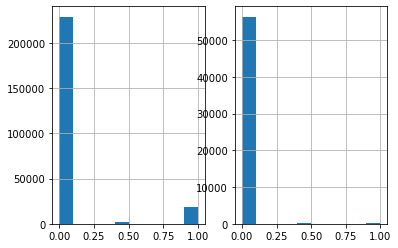

In [62]:
##Probability Distribution
fig, axes = plt.subplots(1, 2)
##Train
pd.Series(model.predict_proba(X_ada_train)[:,1]).hist(figsize=(6, 4), ax=axes[0])
##Test
pd.Series(model.predict_proba(X_test)[:,1]).hist(figsize=(6, 4), ax=axes[1])

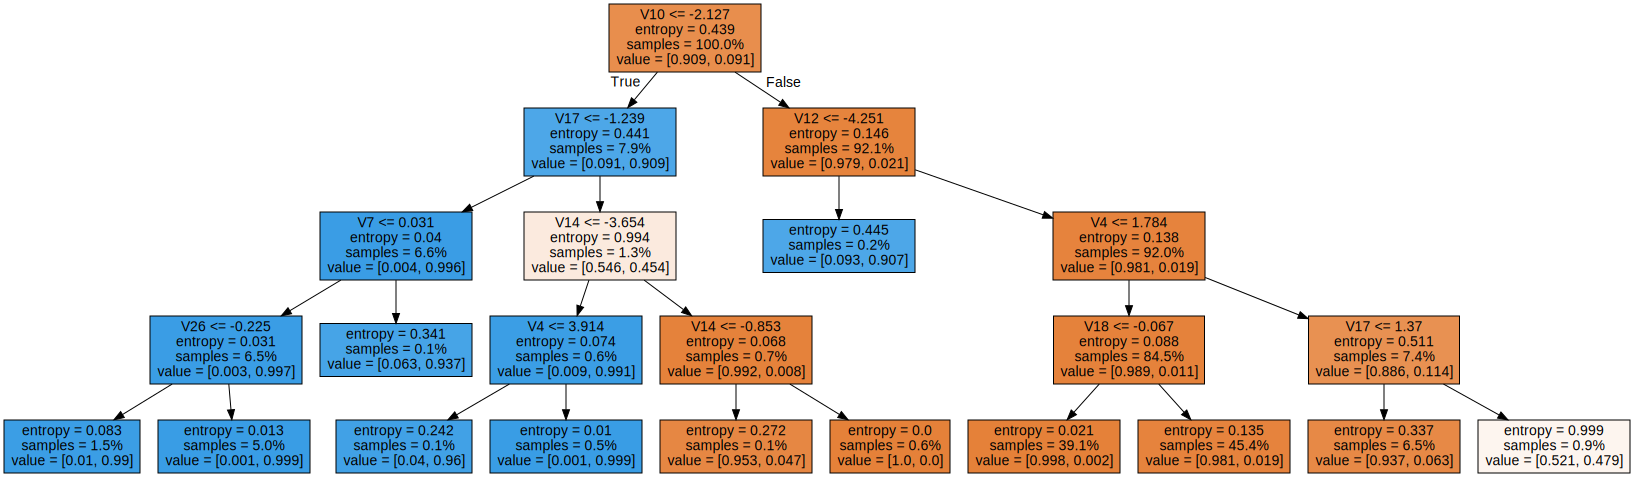

<Figure size 1440x720 with 0 Axes>

In [63]:
##Generate tree
dot_data = tree.export_graphviz(model, out_file=None, 
                                    feature_names=X_ada_train.columns,  
                                    proportion=True,
                                    filled=True)
plt.figure()
graph = graphviz.Source(dot_data, format="png")
graph

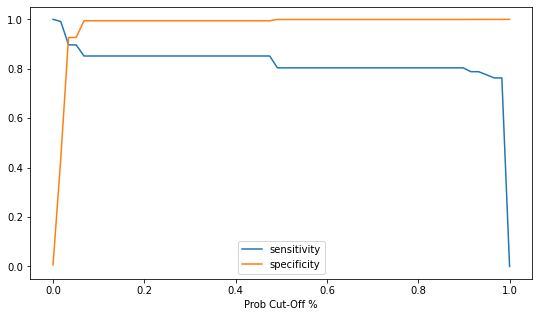

In [64]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
traindf.plot.line(x='Prob Cut-Off %', y=['sensitivity','specificity'],figsize=(9, 5))
plt.show()

- auc roc_value: 0.961
- threshold: 5%
- auc roc_value test dataset: 0.954

**Inference**
- The model seems to be performing well
- V10, V14, V4, V17 are the top 4 features in the model
- We can see that the model is slightly overfitting to some extent.
- Probability cut-off should be ~5% as it gives stable sensitivity (89%) and specificity (92%)

In [65]:
model_output= (X_ada_train.columns.tolist(),model)
output = open('DT_credit_fraud.pkl', 'wb')
pickle.dump(model_output, output)
output.close()

## Random Forest Classifier

In [66]:
##Base Model
model = RandomForestClassifier(random_state=420)
model.fit(X_ada_train, y_ada_train)

model_stat= pd.DataFrame(zip(X_ada_train.columns,model.feature_importances_),columns=['Model Parameters','Weightage'])
model_stat.sort_values('Weightage',ascending=False,inplace=True)

# check the accuracy on the training set
testdf=pd.DataFrame()
traindf=pd.DataFrame()
cut_off = np.linspace(0,1,2)
for thresh in cut_off:
    train_df,test_df= class_accuracy(thresh,model,X_test,X_ada_train,y_test,y_ada_train)
    traindf = traindf.append(train_df)
    testdf = testdf.append(test_df)
traindf.reset_index(inplace=True)
testdf.reset_index(inplace=True)
print ('Train AUC: ',traindf['AUC'].iloc[0])
print ('Test AUC: ',testdf['AUC'].iloc[0])

Train AUC:  1.0
Test AUC:  0.9717023622939717


**Inference**
- The model is clearly overfitting
- 'V1', 'V2', 'V3', 'V4' are the top 4 features in the model
- We will need to fine tune the hyperparameters to reduce the overfitting

### Perform hyperparameter tuning to reduce overfitting and get better overall performace

In [67]:
## we want to optimise two main hyperparameters i.e. max depth and minimum samples in leaf node

In [68]:
##Keeping max_depth = 10
model = RandomForestClassifier(random_state=420,max_depth=9)
model.fit(X_ada_train, y_ada_train)
# check the accuracy on the training set
testdf=pd.DataFrame()
traindf=pd.DataFrame()
thresh= 0
train_df,test_df= class_accuracy(thresh,model,X_test,X_ada_train,y_test,y_ada_train)
traindf = traindf.append(train_df)
testdf = testdf.append(test_df)
traindf.reset_index(inplace=True)
testdf.reset_index(inplace=True)
print ('Train AUC: ',traindf['AUC'].iloc[0])
print ('Test AUC: ',testdf['AUC'].iloc[0])

Train AUC:  0.99644896698749
Test AUC:  0.9847773393696772


In [69]:
##Keeping min_samples_leaf = 100
model = RandomForestClassifier(random_state=420,min_samples_leaf=500)
model.fit(X_ada_train, y_ada_train)
# check the accuracy on the training set
testdf=pd.DataFrame()
traindf=pd.DataFrame()
thresh= 0
train_df,test_df= class_accuracy(thresh,model,X_test,X_ada_train,y_test,y_ada_train)
traindf = traindf.append(train_df)
testdf = testdf.append(test_df)
traindf.reset_index(inplace=True)
testdf.reset_index(inplace=True)
print ('Train AUC: ',traindf['AUC'].iloc[0])
print ('Test AUC: ',testdf['AUC'].iloc[0])

Train AUC:  0.9973603716764644
Test AUC:  0.9841572917837657


- As we saw above max_depth at 10 is still overfitting so it can't be more than 10. Also we have high number of features so we will keep the minimum depth as 5.
- With min_samples_leaf=1000, the model is still slightly overfitting

In [70]:
##Perform gridsearchcv
st= time.time()
model = RandomForestClassifier(random_state=420)
params = {
    'max_depth': [5, 6],
    'min_samples_split': [100,150, 250],
    'min_samples_leaf': [100,150, 250],
    'max_features': [7,8,10],
    'n_estimators': [100,150],
    'criterion': ['gini']
        }

grid_search = GridSearchCV(estimator=model, 
                           param_grid=params, 
                           cv=2, n_jobs=-1, verbose=1, scoring = "roc_auc",return_train_score=True)

grid_search.fit(X_train, y_train)
time.time() - st

Fitting 2 folds for each of 108 candidates, totalling 216 fits


3394.899411201477

In [71]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.nlargest(6,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
13,108.422584,0.177696,1.314268,0.028672,gini,5,7,250,100,150,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.974420,0.966727,0.970573,0.003847,1,0.988114,0.989734,0.988924,0.000810
15,107.752859,0.291376,1.176792,0.058328,gini,5,7,250,150,150,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.974420,0.966727,0.970573,0.003847,1,0.988114,0.989734,0.988924,0.000810
17,103.543640,0.254706,1.246711,0.015653,gini,5,7,250,250,150,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.974420,0.966727,0.970573,0.003847,1,0.988114,0.989734,0.988924,0.000810
66,84.751852,0.016510,0.909005,0.011640,gini,6,7,250,100,100,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.971238,0.968983,0.970111,0.001127,4,0.990043,0.992034,0.991039,0.000995
68,84.250064,0.090554,0.891496,0.006618,gini,6,7,250,150,100,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.971238,0.968983,0.970111,0.001127,4,0.990043,0.992034,0.991039,0.000995
70,84.395061,0.037755,0.907958,0.039586,gini,6,7,250,250,100,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.971238,0.968983,0.970111,0.001127,4,0.990043,0.992034,0.991039,0.000995


In [72]:
model_best= grid_search.best_estimator_
model_best.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 7,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 250,
 'min_samples_split': 100,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 420,
 'verbose': 0,
 'warm_start': False}

In [73]:
grid_search= None; del grid_search

In [74]:
model= model_best.fit(X_ada_train, y_ada_train)
# check the accuracy on the training set
testdf=pd.DataFrame()
traindf=pd.DataFrame()
cut_off = np.linspace(0,1,2)
for thresh in cut_off:
    train_df,test_df= class_accuracy(thresh,model,X_test,X_ada_train,y_test,y_ada_train)
    traindf = traindf.append(train_df)
    testdf = testdf.append(test_df)
traindf.reset_index(inplace=True)
testdf.reset_index(inplace=True)
print ('Train AUC: ',traindf['AUC'].iloc[0])
print ('Test AUC: ',testdf['AUC'].iloc[0])

Train AUC:  0.9853843747161768
Test AUC:  0.9832203454391569


The best model doesn't seem to be overfitting and have high accuracy

In [75]:
## Final Model
#increasing the min_sampe_leaf, reducing the max_depth and increasing the max_features
# model = RandomForestClassifier(random_state=69,max_depth=5,min_samples_split= 100,min_samples_leaf= 150,
#                                criterion= 'gini',max_features=8,n_estimators=120)
# model.fit(X_ada_train, y_ada_train)

model= model_best.fit(X_ada_train, y_ada_train)

model_stat= pd.DataFrame(zip(X_ada_train.columns,model.feature_importances_),columns=['Model Parameters','Weightage'])
model_stat.sort_values('Weightage',ascending=False,inplace=True)

# check the accuracy on the training set
testdf=pd.DataFrame()
traindf=pd.DataFrame()
cut_off = np.linspace(0,1,60)
for thresh in cut_off:
    train_df,test_df= class_accuracy(thresh,model,X_test,X_ada_train,y_test,y_ada_train)
    traindf = traindf.append(train_df)
    testdf = testdf.append(test_df)
traindf.reset_index(inplace=True)
testdf.reset_index(inplace=True)
print ('Train AUC: ',traindf['AUC'].iloc[0])
print ('Test AUC: ',testdf['AUC'].iloc[0])

Train AUC:  0.9853843747161768
Test AUC:  0.9832203454391569


In [76]:
model_stat= pd.DataFrame(zip(X_ada_train.columns,model.feature_importances_),columns=['Model Parameters','Weightage'])
model_stat.sort_values('Weightage',ascending=False)[:5]

,Model Parameters,Weightage
12,V14,0.296265
15,V17,0.174751
8,V10,0.146801
10,V12,0.114996
9,V11,0.098132


In [77]:
traindf[2:15]

,Prob Cut-Off %,AUC,GINI,sensitivity,specificity,F1 Score,False Positive,True Positive,False Negative,True Negative,IU
2,0.033898,0.985384,0.970769,0.948588,0.901819,0.918691,22248,21495,1165,204354,0.120362
3,0.050847,0.985384,0.970769,0.919682,0.964458,0.962506,8054,20840,1820,218548,0.086629
4,0.067797,0.985384,0.970769,0.897485,0.982471,0.975143,3972,20337,2323,222630,0.090813
5,0.084746,0.985384,0.970769,0.878288,0.988354,0.978322,2639,19902,2758,223963,0.110066
6,0.101695,0.985384,0.970769,0.872418,0.990865,0.979932,2070,19769,2891,224532,0.118447
7,0.118644,0.985384,0.970769,0.867255,0.992246,0.980639,1757,19652,3008,224845,0.124991
8,0.135593,0.985384,0.970769,0.864519,0.993482,0.981458,1477,19590,3070,225125,0.128963
9,0.152542,0.985384,0.970769,0.862798,0.994775,0.982432,1184,19551,3109,225418,0.131977
10,0.169492,0.985384,0.970769,0.860635,0.995543,0.982902,1010,19502,3158,225592,0.134907
11,0.186441,0.985384,0.970769,0.857282,0.996368,0.983310,823,19426,3234,225779,0.139087


In [78]:
testdf[2:15]

,Prob Cut-Off %,AUC,GINI,sensitivity,specificity,F1 Score,False Positive,True Positive,False Negative,True Negative,IU
2,0.033898,0.98322,0.966441,0.936842,0.898554,0.944980,5747,89,6,50904,0.131044
3,0.050847,0.98322,0.966441,0.905263,0.962631,0.979363,2117,86,9,54534,0.098547
4,0.067797,0.98322,0.966441,0.905263,0.981854,0.989344,1028,86,9,55623,0.079324
5,0.084746,0.98322,0.966441,0.905263,0.987626,0.992358,701,86,9,55950,0.082363
6,0.101695,0.98322,0.966441,0.894737,0.990274,0.993748,551,85,10,56100,0.095537
7,0.118644,0.98322,0.966441,0.894737,0.991845,0.994594,462,85,10,56189,0.097108
8,0.135593,0.98322,0.966441,0.894737,0.992833,0.995133,406,85,10,56245,0.098096
9,0.152542,0.98322,0.966441,0.894737,0.993945,0.995751,343,85,10,56308,0.099209
10,0.169492,0.98322,0.966441,0.884211,0.994987,0.996328,284,84,11,56367,0.110776
11,0.186441,0.98322,0.966441,0.884211,0.995887,0.996854,233,84,11,56418,0.111677


<AxesSubplot:>

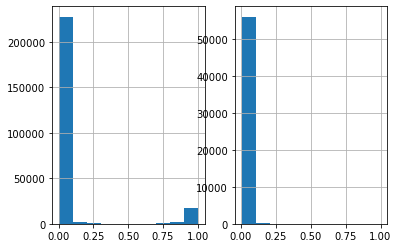

In [79]:
##Probability Distribution
fig, axes = plt.subplots(1, 2)
##Train
pd.Series(model.predict_proba(X_ada_train)[:,1]).hist(figsize=(6, 4), ax=axes[0])
##Test
pd.Series(model.predict_proba(X_test)[:,1]).hist(figsize=(6, 4), ax=axes[1])

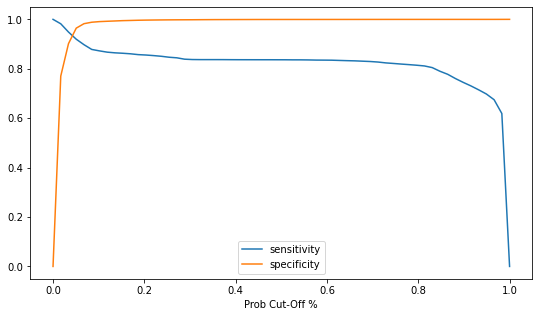

In [80]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
traindf.plot.line(x='Prob Cut-Off %', y=['sensitivity','specificity'],figsize=(9, 5))
plt.show()

- auc roc_value: 0.985
- threshold: 3.5%
- auc roc_value test dataset: 0.983

**Inference**
- The model seems to be performing well
- 'V14', 'V17', 'V12', 'V10', are the top 4 features in the model
- We can see that the model is no longer overfitting.
- Probability cut-off should be ~3.5% as it gives stable sensitivity (94%) and specificity (91%)

In [81]:
model_output= (X_ada_train.columns.tolist(),model)
output = open('RF_credit_fraud.pkl', 'wb')
pickle.dump(model_output, output)
output.close()

## XGBoost Classifier

In [82]:
model= XGBClassifier()
model.fit(X_ada_train, y_ada_train)
model_stat= pd.DataFrame(zip(X_ada_train.columns,model.feature_importances_),columns=['Model Parameters','Weightage'])

# check the accuracy on the training set
testdf=pd.DataFrame()
traindf=pd.DataFrame()
cut_off = np.linspace(0,1,2)
for thresh in cut_off:
    train_df,test_df= class_accuracy(thresh,model,X_test,X_ada_train,y_test,y_ada_train,xgb=True)
    traindf = traindf.append(train_df)
    testdf = testdf.append(test_df)
traindf.reset_index(inplace=True)
testdf.reset_index(inplace=True)
print ('Train AUC: ',traindf['AUC'].iloc[0])
print ('Test AUC: ',testdf['AUC'].iloc[0])

Train AUC:  1.0
Test AUC:  0.9803851653104093


In [83]:
model_params= {'colsample_bytree': 0.6, 'gamma': 2.7, 'learning_rate': 0.1, 'max_depth': 4, "n_estimators":350,
              'min_child_weight': 100}

In [84]:
rows = random.sample(np.arange(0,len(X_ada_train.index)).tolist(), 42000)
print (y_ada_train.iloc[rows,].value_counts(normalize=True))

params = {
"gamma":[0.7, 1.7, 2.7, 3.7],
"max_depth":[4, 5],
"min_child_weight": [100],
"colsample_bytree": [0.4, 0.6],
"learning_rate": [0.1, 0.01],
"n_estimators": [250, 350]
}
xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)

grid_search = GridSearchCV(estimator=xgb, param_grid=params, scoring="roc_auc", n_jobs=1, cv=skf.split(X_ada_train.iloc[rows,], y_ada_train.iloc[rows,]), verbose=1)

grid_search.fit(X_ada_train.iloc[rows,], y_ada_train.iloc[rows,])

print ("Best estimator: ")
print (grid_search.best_estimator_)
print ("Parameters: ", grid_search.best_params_)
print ("Highest AUC: %.2f" % grid_search.best_score_)

print (grid_search.best_params_)
model_params= grid_search.best_params_

0    0.909738
1    0.090262
Name: target, dtype: float64
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best estimator: 
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0.7, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=100, missing=nan,
              monotone_constraints='()', n_estimators=350, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)
Parameters:  {'colsample_bytree': 0.6, 'gamma': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 100, 'n_estimators': 350}
Highest AUC: 1

In [85]:
model = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
model.set_params(**model_params)
model.fit(X_ada_train, y_ada_train)

model_stat= pd.DataFrame(zip(X_ada_train.columns,model.feature_importances_),columns=['Model Parameters','Weightage'])

# check the accuracy on the training set
testdf=pd.DataFrame()
traindf=pd.DataFrame()
# cut_off = np.linspace(0,1,2)
cut_off= [0]
for thresh in cut_off:
    train_df,test_df= class_accuracy(thresh,model,X_test,X_ada_train,y_test,y_ada_train,xgb=True)
    traindf = traindf.append(train_df)
    testdf = testdf.append(test_df)
traindf.reset_index(inplace=True)
testdf.reset_index(inplace=True)
print ('Train AUC: ',traindf['AUC'].iloc[0])
print ('Test AUC: ',testdf['AUC'].iloc[0])

Train AUC:  0.9999244184972672
Test AUC:  0.9865837830706755


In [86]:
## manual finetuning of the hyperparameters to redue overfitting
model_params= {'colsample_bytree': 0.6, 'gamma': 2.7, 'learning_rate': 0.1, 'max_depth': 4, "n_estimators":350,
              'min_child_weight': 100}

model = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False) #
model.set_params(**model_params)
model.fit(X_ada_train, y_ada_train)

model_stat= pd.DataFrame(zip(X_ada_train.columns,model.feature_importances_),columns=['Model Parameters','Weightage'])
model_stat.sort_values('Weightage',ascending=False,inplace=True)

# check the accuracy on the training set
testdf=pd.DataFrame()
traindf=pd.DataFrame()
cut_off = np.linspace(0,1,70)
for thresh in cut_off:
    train_df,test_df= class_accuracy(thresh,model,X_test,X_ada_train,y_test,y_ada_train,xgb=True)
    traindf = traindf.append(train_df)
    testdf = testdf.append(test_df)
traindf.reset_index(inplace=True)
testdf.reset_index(inplace=True)
print ('Train AUC: ',traindf['AUC'].iloc[0])
print ('Test AUC: ',testdf['AUC'].iloc[0])

Train AUC:  0.9999180888463276
Test AUC:  0.9885894149682869


In [87]:
model_stat= pd.DataFrame(zip(X_ada_train.columns,model.feature_importances_),columns=['Model Parameters','Weightage'])
model_stat.sort_values('Weightage',ascending=False)[:5]

,Model Parameters,Weightage
12,V14,0.316434
15,V17,0.202660
8,V10,0.089239
10,V12,0.085178
3,V4,0.037797


In [88]:
traindf[2:15]

,Prob Cut-Off %,AUC,GINI,sensitivity,specificity,F1 Score,False Positive,True Positive,False Negative,True Negative,IU
2,0.028986,0.999918,0.999836,1.000000,0.977542,0.980498,5089,22660,0,221513,0.022458
3,0.043478,0.999918,0.999836,1.000000,0.984576,0.986426,3495,22660,0,223107,0.015424
4,0.057971,0.999918,0.999836,0.999868,0.988553,0.989833,2594,22657,3,224008,0.011416
5,0.072464,0.999918,0.999836,0.999470,0.990821,0.991771,2080,22648,12,224522,0.009545
6,0.086957,0.999918,0.999836,0.999294,0.992445,0.993180,1712,22644,16,224890,0.008097
7,0.101449,0.999918,0.999836,0.999162,0.993583,0.994172,1454,22641,19,225148,0.007091
8,0.115942,0.999918,0.999836,0.999029,0.994475,0.994949,1252,22638,22,225350,0.006332
9,0.130435,0.999918,0.999836,0.998985,0.995181,0.995573,1092,22637,23,225510,0.005670
10,0.144928,0.999918,0.999836,0.998897,0.995763,0.996084,960,22635,25,225642,0.005176
11,0.159420,0.999918,0.999836,0.998500,0.996214,0.996450,858,22626,34,225744,0.005123


In [89]:
testdf[2:15]

,Prob Cut-Off %,AUC,GINI,sensitivity,specificity,F1 Score,False Positive,True Positive,False Negative,True Negative,IU
2,0.028986,0.988589,0.977179,0.905263,0.975075,0.985829,1412,86,9,55239,0.096840
3,0.043478,0.988589,0.977179,0.905263,0.982101,0.989472,1014,86,9,55637,0.089815
4,0.057971,0.988589,0.977179,0.905263,0.986514,0.991774,764,86,9,55887,0.085402
5,0.072464,0.988589,0.977179,0.905263,0.989179,0.993179,613,86,9,56038,0.083916
6,0.086957,0.988589,0.977179,0.894737,0.991033,0.994155,508,85,10,56143,0.096296
7,0.101449,0.988589,0.977179,0.894737,0.992516,0.994959,424,85,10,56227,0.097779
8,0.115942,0.988589,0.977179,0.894737,0.993504,0.995504,368,85,10,56283,0.098767
9,0.130435,0.988589,0.977179,0.894737,0.994387,0.995999,318,85,10,56333,0.099650
10,0.144928,0.988589,0.977179,0.894737,0.995005,0.996353,283,85,10,56368,0.100268
11,0.159420,0.988589,0.977179,0.894737,0.995622,0.996713,248,85,10,56403,0.100885


<AxesSubplot:>

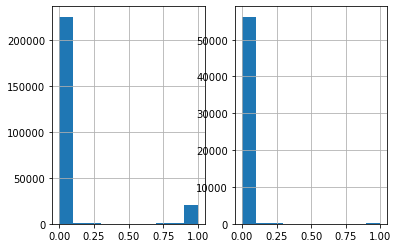

In [90]:
##Probability Distribution
fig, axes = plt.subplots(1, 2)
##Train
pd.Series(model.predict_proba(X_ada_train)[:,1]).hist(figsize=(6, 4), ax=axes[0])
##Test
pd.Series(model.predict_proba(X_test)[:,1]).hist(figsize=(6, 4), ax=axes[1])

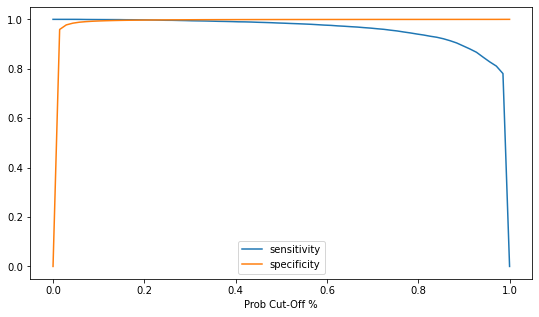

In [91]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
traindf.plot.line(x='Prob Cut-Off %', y=['sensitivity','specificity'],figsize=(9, 5))
plt.show()

- auc roc_value: 0.999
- threshold: 7.2%
- auc roc_value test dataset: 0.988

**Inference**
- The model seems to be performing well
- 'V14', 'V17', 'V10', 'V12', are the top 4 features in the model
- We can see that the model is slightly overfitting but seems to be very low.
- Probability cut-off should be ~7.2% as it gives stable sensitivity (99%) and specificity (99%)

In [92]:
model_output= (X_ada_train.columns.tolist(),model)
output = open('XG_credit_fraud.pkl', 'wb')
pickle.dump(model_output, output)
output.close()

## Testing the final model with Adasyn Oversampling

In [93]:
X_adas_train, y_adas_train = ADASYN(sampling_strategy=0.1,random_state=420).fit_resample(X_train, y_train)

In [94]:
## manual finetuning of the hyperparameters to redue overfitting
model_params= {'colsample_bytree': 0.6, 'gamma': 2.7, 'learning_rate': 0.1, 'max_depth': 4, "n_estimators":350,
              'min_child_weight': 100}

model = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False) #
model.set_params(**model_params)
model.fit(X_adas_train, y_adas_train)

model_stat= pd.DataFrame(zip(X_adas_train.columns,model.feature_importances_),columns=['Model Parameters','Weightage'])
model_stat.sort_values('Weightage',ascending=False,inplace=True)

# check the accuracy on the training set
testdf=pd.DataFrame()
traindf=pd.DataFrame()
cut_off = np.linspace(0,1,70)
for thresh in cut_off:
    train_df,test_df= class_accuracy(thresh,model,X_test,X_adas_train,y_test,y_adas_train,xgb=True)
    traindf = traindf.append(train_df)
    testdf = testdf.append(test_df)
traindf.reset_index(inplace=True)
testdf.reset_index(inplace=True)
print ('Train AUC: ',traindf['AUC'].iloc[0])
print ('Test AUC: ',testdf['AUC'].iloc[0])

Train AUC:  0.9998676673597706
Test AUC:  0.9870022269314705


## Testing the final model with Random Oversampling

In [95]:
X_random_train, y_random_train = RandomOverSampler(sampling_strategy=0.1,random_state=420).fit_resample(X_train, y_train)

In [96]:
## manual finetuning of the hyperparameters to redue overfitting
model_params= {'colsample_bytree': 0.6, 'gamma': 2.7, 'learning_rate': 0.1, 'max_depth': 4, "n_estimators":350,
              'min_child_weight': 100}

model = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False) #
model.set_params(**model_params)
model.fit(X_random_train, y_random_train)

model_stat= pd.DataFrame(zip(X_random_train.columns,model.feature_importances_),columns=['Model Parameters','Weightage'])
model_stat.sort_values('Weightage',ascending=False,inplace=True)

# check the accuracy on the training set
testdf=pd.DataFrame()
traindf=pd.DataFrame()
cut_off = np.linspace(0,1,70)
for thresh in cut_off:
    train_df,test_df= class_accuracy(thresh,model,X_test,X_random_train,y_test,y_random_train,xgb=True)
    traindf = traindf.append(train_df)
    testdf = testdf.append(test_df)
traindf.reset_index(inplace=True)
testdf.reset_index(inplace=True)
print ('Train AUC: ',traindf['AUC'].iloc[0])
print ('Test AUC: ',testdf['AUC'].iloc[0])

Train AUC:  0.9999553190112523
Test AUC:  0.983645385550866


We get very similar results with ADASYN over-sampling as compared to Smote over-sampling apart from random oveer-sampling which shows slightly less accuracy

# Final Model: XgBoost Classifier

**Hyperparameters**: {'colsample_bytree': 0.6, 'gamma': 2.7, 'learning_rate': 0.1, 'max_depth': 4, "n_estimators":350,
              'min_child_weight': 100}

**Evaluation Metrics:**
- **Train AUC:**  0.999
- **Test AUC:**  0.988

**Cut-off:** 7.24%
- **Sensitivity:** 99%
- **Specificity:** 99%

**Top Features:** 'V14', 'V17', 'V10', 'V12'

**We wil go foreward with XgBoost model because of the below reasons:**
- Since the labeles were imbalanced, we used AUC and sensitivity and specificity as the evaluation metrics 
- It shows the highest Traina and Test AUC
- We barely see any overfitting
- The Sensitivity and Specificity is stable across different probability cut-offs